In [1]:
import pandas as pd
import numpy as np
#surpress divide warnings
np.errstate(invalid='ignore', divide='ignore')
import matplotlib.pyplot as plt
import pickle
from src.data_tools.get_data import get_data

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from src.plotting_tools.draw_stack_plot_hists import draw_bckground, draw_signals, draw_data, draw_stackplot
from src.plotting_tools.SysHist import SysHist
from src.plotting_tools.Bins import Bins, bins
from src.plotting_tools.utils import ratio_plot_template
from src.data_tools.StackPlotter import get_stack_plotter
from src.plotting_tools.latexAssets import mll
from src.assets.output_dir import output_dir
output_dir

'/eos/cms/store/group/phys_exotica/bffZprime/assets_june_23'

In [5]:
split_bins = bins

In [6]:
from src.general.array_utils import moving_average, moving_sum, super_sample, super_sample_function, moving_avg_func, unp_array_to_nom_std
from src.plotting_tools.cms_format import cms_style, cms_format_fig

In [7]:
from scipy.optimize import curve_fit
from src.general.functions import power_func, power_law, make_bpoly, linear, parabola, make_bpoly_exp

/cvmfs/cms.cern.ch/slc7_amd64_gcc900/external/py3-scipy/1.7.1-c59502069094870046fda47cb5a5065e/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [8]:
from scipy.optimize import curve_fit
from src.general.functions import make_bpoly, lognorm, log_norm_np, log_norm_unp
from src.plotting_tools.SysHist import SysHist
import uncertainties
import uncertainties.unumpy as unp

In [9]:
cms_style()

In [10]:
outdir = '{}/abcd_test'.format(output_dir)
era = '2016'
ismc=1
isdata = ismc==0

#select the median version 
ismedian = False
if ismedian: postfix="_median"
else: postfix=""

In [11]:
sp = get_stack_plotter(output_dir, era, bins='none')

In [12]:
def compare_hists(fhist, dhist, ismc_pull = False, n=10, ndof=0, log=1, color='red', flabel="", dlabel="", 
                  dhist_isdata=0, fhist_is_data=0, ratio=False,  isabcd=0, **kwargs):
    fig, ax, rax = ratio_plot_template(figsize=(10,10))
    
    if isabcd:
        fhist.draw(ax, label=flabel, zorder=3,color=color)
    else:
        fhist.draw(ax, label=flabel, zorder=3)
    if dhist_isdata:
        ax.errorbar(dhist.calc_bin_centers(), dhist.nominal, yerr=dhist.std, color='black', label=dlabel,
           ls='', marker='o', zorder=3)
    else:
        dhist.draw(ax, label=dlabel, zorder=1, color=color, errorbar=False, draw_sys=0)#, sys_label='Background Systematics')
    
    x = fhist.calc_bin_centers()
    if isdata:
        cms_format_fig(era, ax, "\emph{Preliminary}")
    else:
        cms_format_fig(era, ax, "\emph{Simulation}")
    if log:
        ax.set_yscale('Log')
    ax.set_ylabel('Counts per GeV')
    
    #calc pull
    nom1_avg = moving_sum(fhist.nominal, n = n)
    nom2_avg = moving_sum(dhist.nominal, n = n)
    var1_avg = moving_sum(fhist.std**2, n = n)
    var2_avg = moving_sum(dhist.std**2, n = n)
    x_avg = moving_average(x, n=n)
    if ismc_pull:
        pull = (nom1_avg-nom2_avg)/(var2_avg+var1_avg)**.5
    else:
        pull = (nom1_avg-nom2_avg)/nom1_avg**.5
    pullsquare = pull**2
        
    
    if ratio:
        rax.plot(x, np.full(len(x), .5) , color='black', linestyle=':')
        rax.plot(x, np.full(len(x), 0) , color='black')
        rax.plot(x, np.full(len(x), 1.5) , color='black', linestyle=':') 
        rax.set_ylim(0,2)
        if fhist_is_data:
            rax.set_ylabel('Obs./Data')
        else:
            if isabcd: rax.set_ylabel('ABCD/MC')
            else: rax.set_ylabel('Fit/MC')
        if isdata:
            fhist.calc_ratio(dhist.nominal).draw(rax, zorder=1, color=color)
        else:
            fhist.calc_ratio(dhist.nominal).draw(rax, zorder=1)
        if dhist_isdata:
            dhist.calc_ratio(dhist.nominal).draw(rax, color=color, zorder=0)
        else:
            dhist.calc_ratio(dhist.nominal).draw(rax, color=color, zorder=0, errorbar=False)
    else:
        rax.plot(x, np.full(len(x), 1) , color='black', linestyle=':')
        rax.plot(x, np.full(len(x), 0) , color='black')
        rax.plot(x, np.full(len(x), -1) , color='black', linestyle=':')
        rax.set_ylim(-5,5)
        rax.set_ylabel('Pull')
        rax.plot(x_avg, pull)
        
    rax.set_xlabel('{} [GeV]'.format(mll))
    return  {'chi2': (pullsquare).sum()/(fhist.calc_nBins()-ndof),
             'fig': fig,
             'ax': ax,
             'rax': rax}
    

In [13]:
def fit_hist(func, hist, n=10, comp_hist_n =10, do_super_sample=1, ismc=False,  do_unc=1, color='red', 
             flabel="", dlabel="", dhist_isdata=0, fhist_is_data=0, **kwargs):
    x = np.array(hist.calc_bin_centers())
    if not isdata:
        popt, pcov = curve_fit(func, x, hist.nominal, 
                       **kwargs,
                       sigma=hist.std, maxfev = int(1e6))  
    else:
        #std is not optimal for data: zero and low count bins will be subotimal error estimates
        popt, pcov = curve_fit(func, x, hist.nominal, 
               **kwargs, maxfev = int(1e6))  
    if do_unc:
        #create fit values with uncertainties
        popt_unc = uncertainties.correlated_values(popt, pcov)
        #make_fit_hist
        y = log_norm_unp(x, *popt_unc)
        y_nom, y_std = unp_array_to_nom_std(y)
    else: 
        y_nom = func(x, *popt)
        varper = ((hist.nominal-y_nom)**2/y_nom).mean()
        y_std = (varper*y_nom)**.5
        y_std = y_nom**.5
    fit_hist = SysHist(
            y_nom,
            x*0, x*0, 
            y_std,
            np.array(hist.bin_edges)
        ).normalize().calc_ratio(1/hist.calc_sum())
    
    #rebin
    fit_hist = fit_hist.rebin(split_bins.bin_edges)
    hist = hist.rebin(split_bins.bin_edges)

    compare_dict = compare_hists(fit_hist, hist, ismc=ismc, n=comp_hist_n, color = color, ndof=5, flabel=flabel, dlabel=dlabel, dhist_isdata=dhist_isdata)
    
    return {**compare_dict, 
            "popt" : np.array(popt),
            "pcov": np.array(pcov),
            "fit_hist": fit_hist
           }

In [14]:
bottom_value = 120
top_value=400
feature='DiLepMass'
sp.x_range = (bottom_value, top_value)

In [15]:
from scipy.ndimage import gaussian_filter

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/tmp/rymuelle/ipykernel_2769/616818785.py:33: RuntimeWarning: invalid value encountered in true_divide
  pull = (nom1_avg-nom2_avg)/nom1_avg**.5


CRA
CRA nan array([1.52393271e+04, 6.83794199e-01, 5.00000000e+01, 8.90330742e+01])


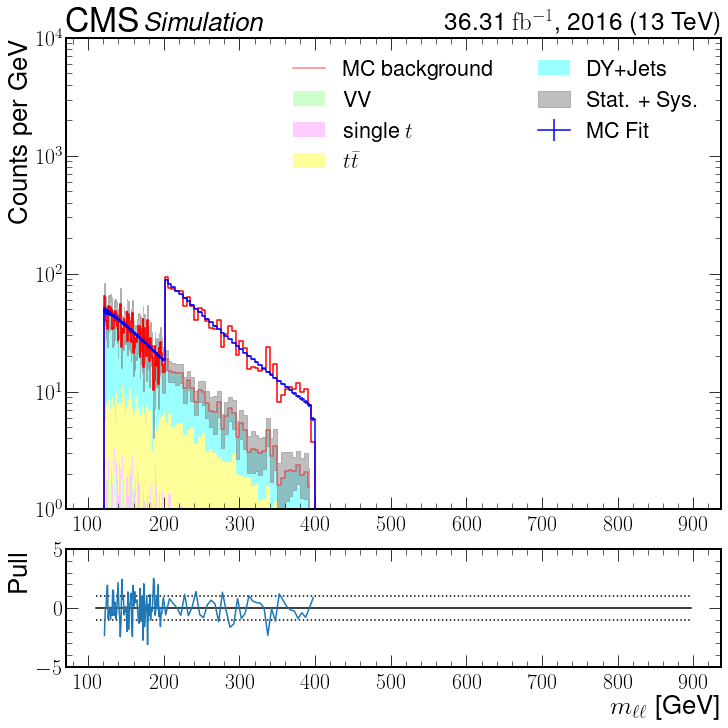

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


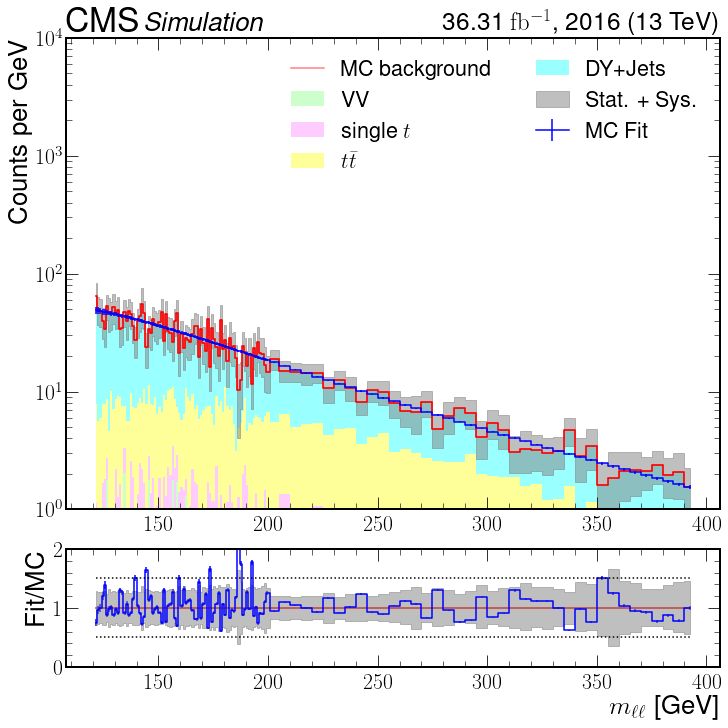

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/tmp/rymuelle/ipykernel_2769/616818785.py:33: RuntimeWarning: invalid value encountered in true_divide
  pull = (nom1_avg-nom2_avg)/nom1_avg**.5


CRB
CRB nan array([9.75018812e+03, 6.13716116e-01, 5.00000000e+01, 9.41709518e+01])


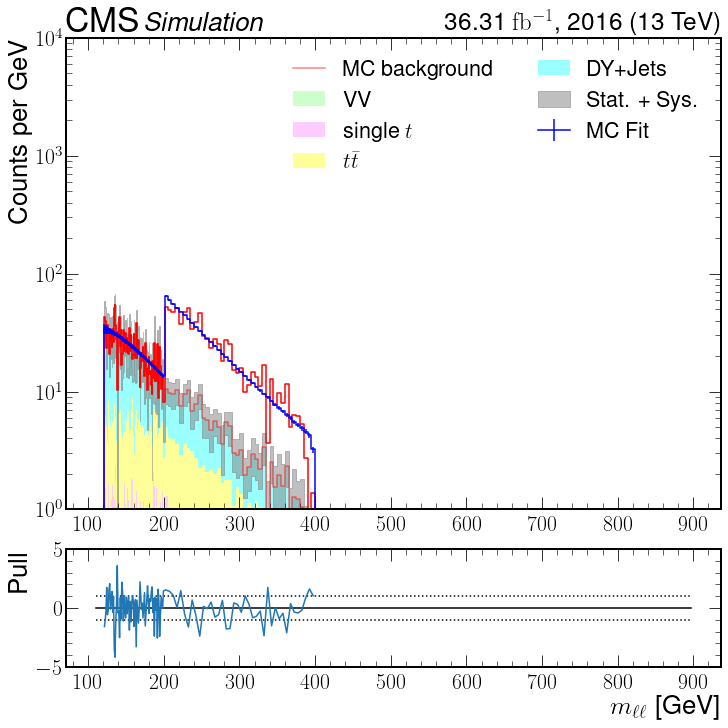

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


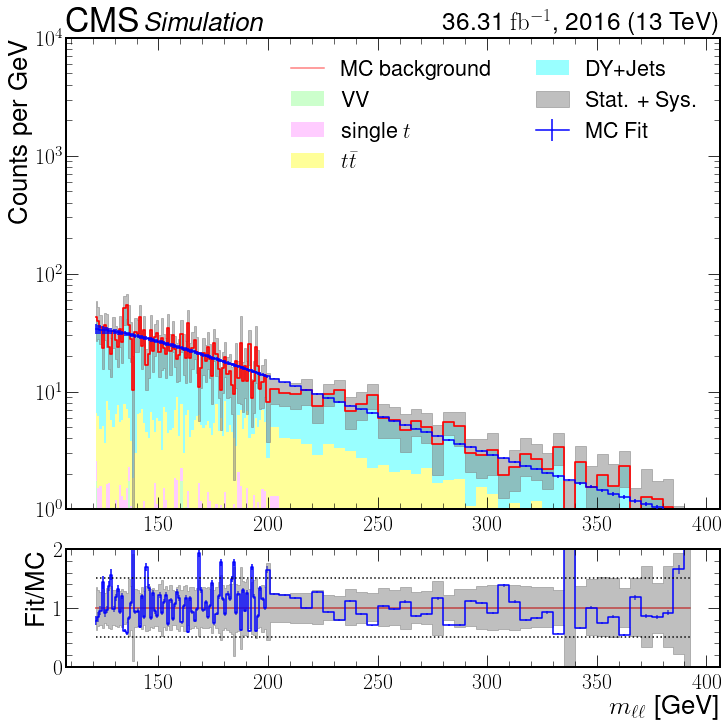

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/tmp/rymuelle/ipykernel_2769/616818785.py:33: RuntimeWarning: invalid value encountered in true_divide
  pull = (nom1_avg-nom2_avg)/nom1_avg**.5


CRC
CRC nan array([5.56939867e+04, 8.20724106e-01, 8.82343382e+01, 6.67725113e+01])


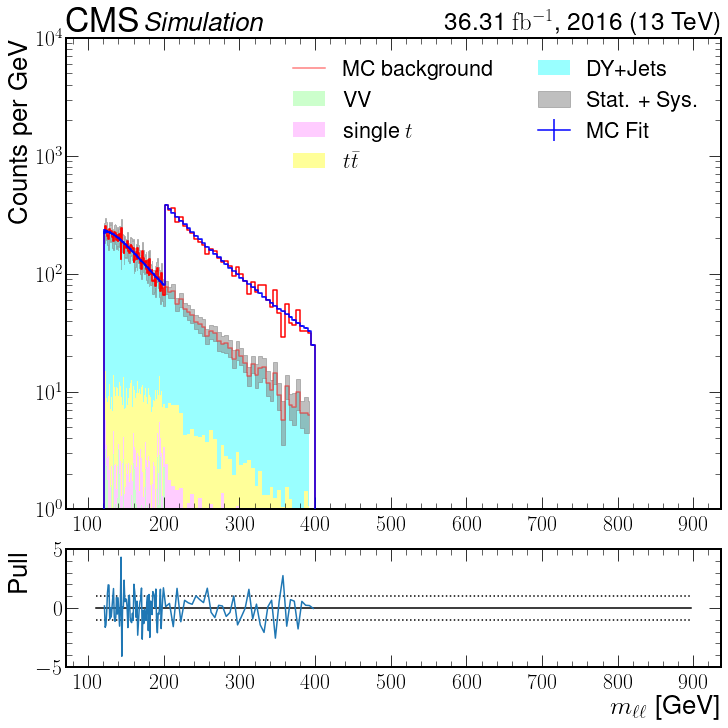

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


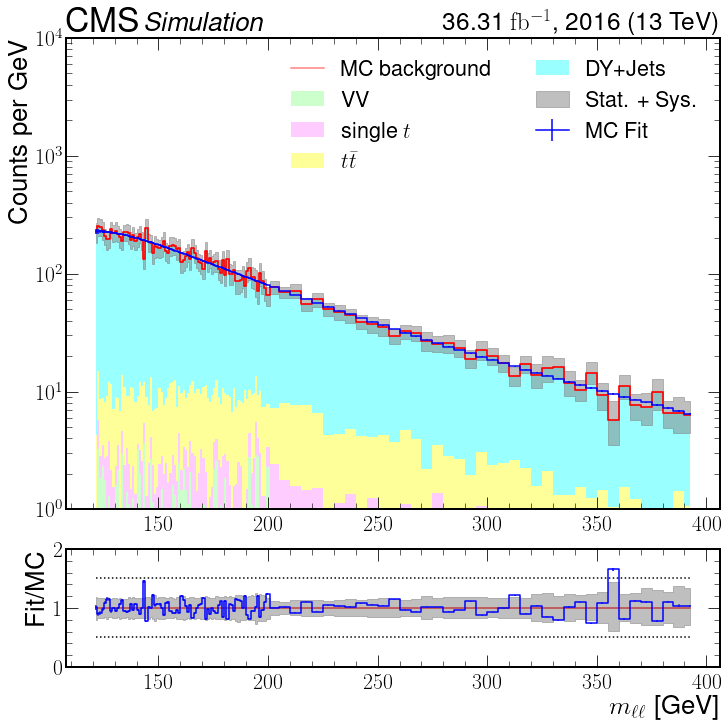

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/tmp/rymuelle/ipykernel_2769/616818785.py:33: RuntimeWarning: invalid value encountered in true_divide
  pull = (nom1_avg-nom2_avg)/nom1_avg**.5


CRD
CRD nan array([1.02838948e+05, 7.59857862e-01, 6.21317313e+01, 7.44403897e+01])


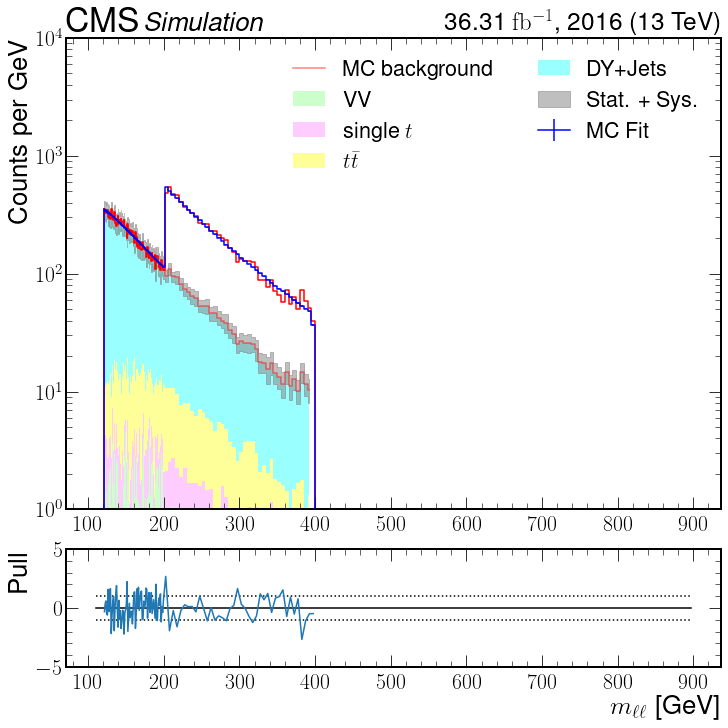

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


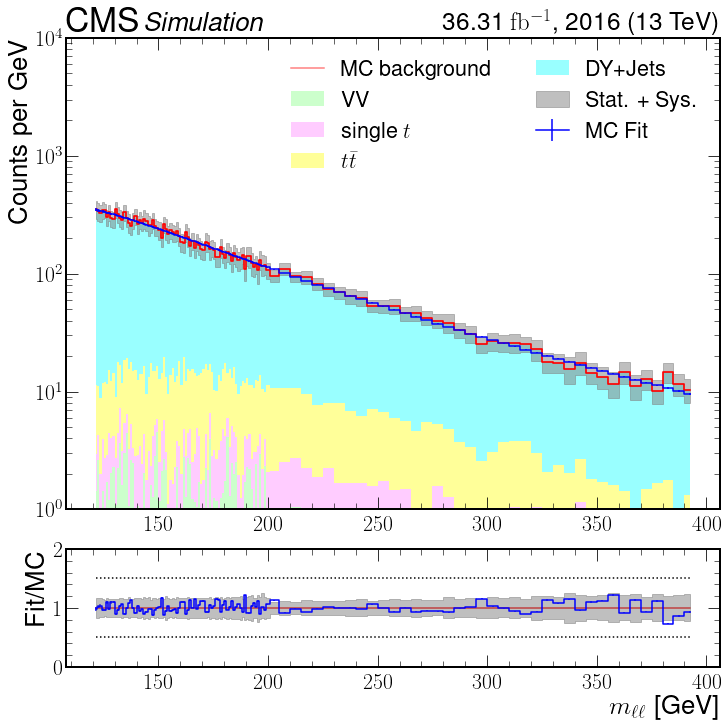

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/tmp/rymuelle/ipykernel_2769/616818785.py:33: RuntimeWarning: invalid value encountered in true_divide
  pull = (nom1_avg-nom2_avg)/nom1_avg**.5


CRA2
CRA2 nan array([7.58376212e+03, 6.65662738e-01, 5.00011225e+01, 1.00000000e+02])


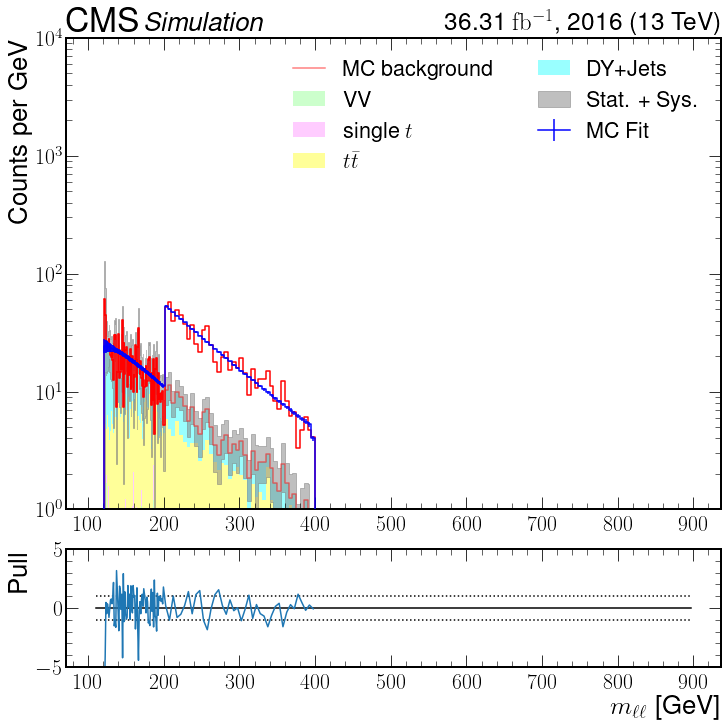

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


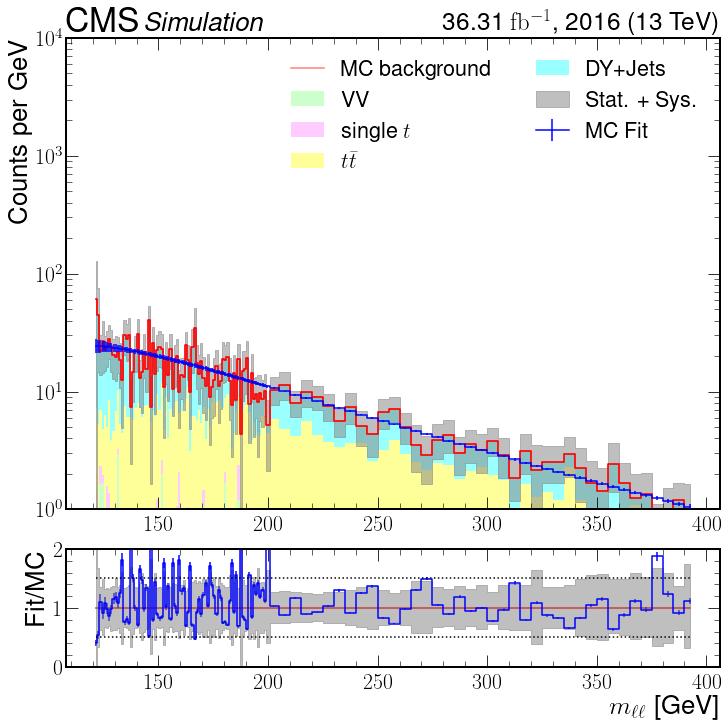

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/tmp/rymuelle/ipykernel_2769/616818785.py:33: RuntimeWarning: invalid value encountered in true_divide
  pull = (nom1_avg-nom2_avg)/nom1_avg**.5
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


CRB2
CRB2 nan array([4.66432626e+03, 6.16605111e-01, 5.42185719e+01, 1.00000000e+02])


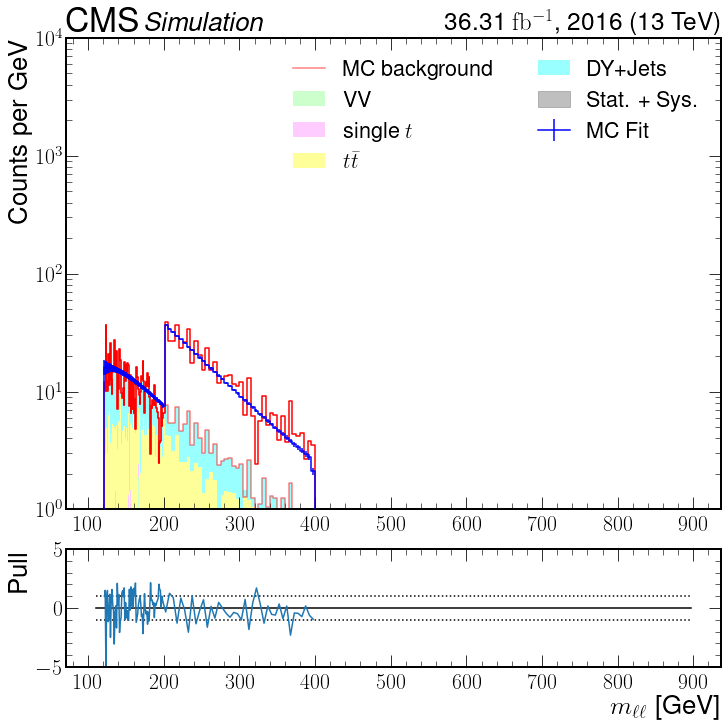

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


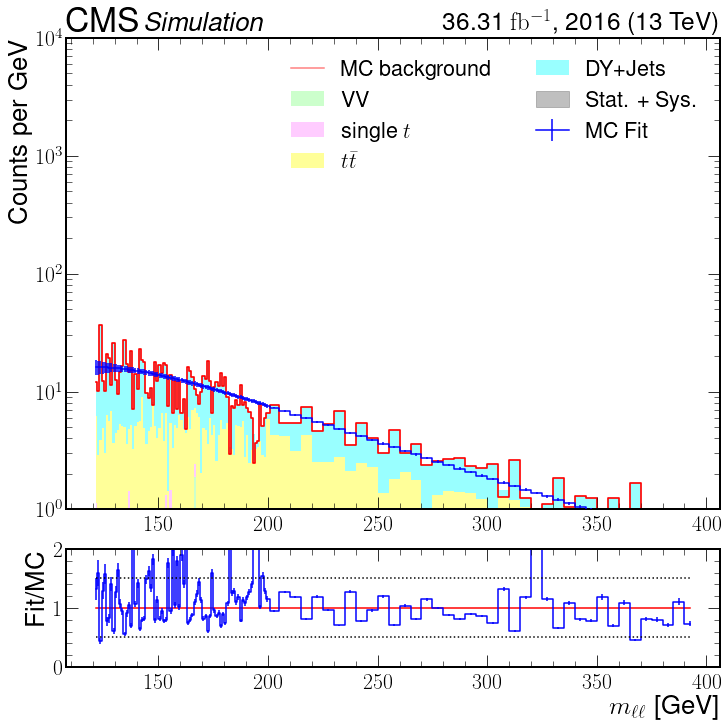

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/tmp/rymuelle/ipykernel_2769/616818785.py:33: RuntimeWarning: invalid value encountered in true_divide
  pull = (nom1_avg-nom2_avg)/nom1_avg**.5


CRC2
CRC2 nan array([1.53251783e+04, 7.14857366e-01, 5.00000000e+01, 8.60645233e+01])


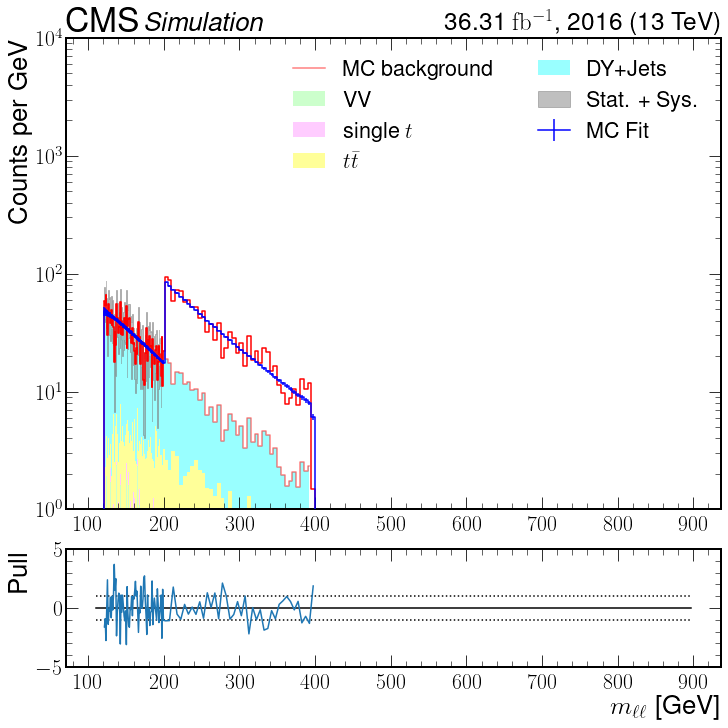

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


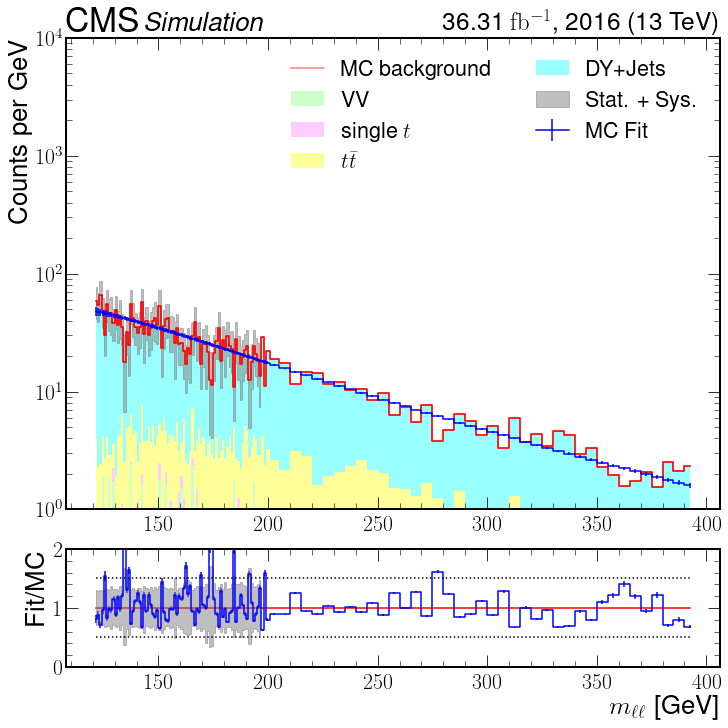

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/tmp/rymuelle/ipykernel_2769/616818785.py:33: RuntimeWarning: invalid value encountered in true_divide
  pull = (nom1_avg-nom2_avg)/nom1_avg**.5
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


CRD2
CRD2 nan array([2.44975037e+04, 7.98880807e-01, 5.00000000e+01, 7.87612134e+01])


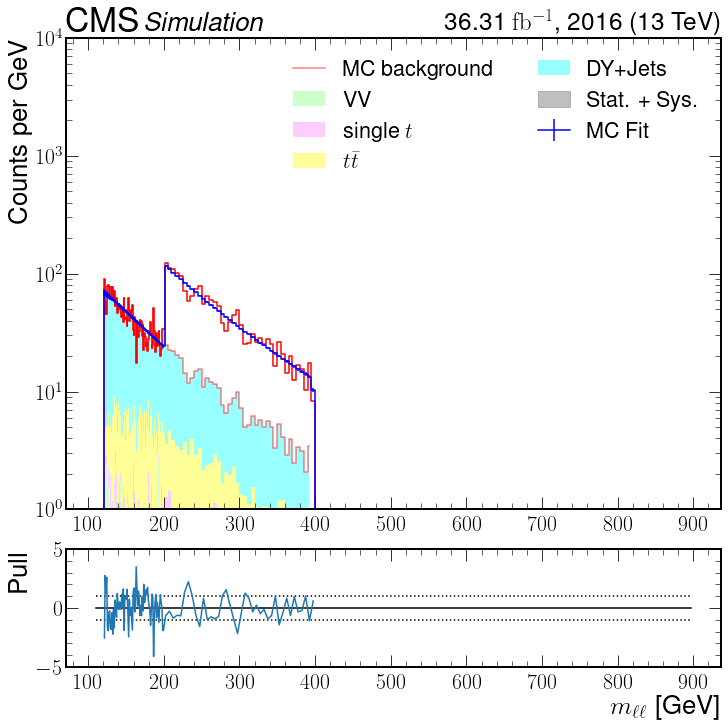

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


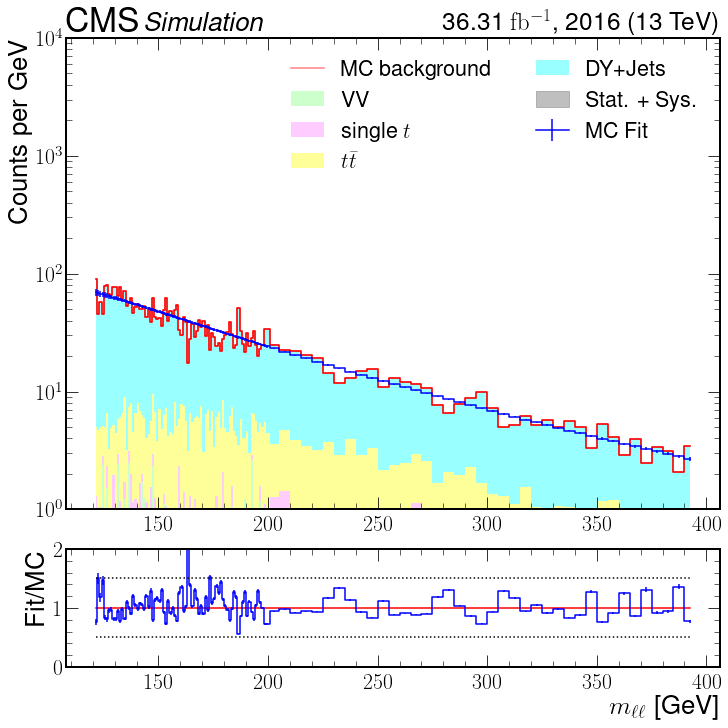

In [27]:
#test_regions = ["CRA_median", "CRB_median", "CRC_median", "CRD_median", "CRA2_median", "CRB2_median", "CRC2_median", "CRD2_median"]
test_regions = ["CRA", "CRB", "CRC", "CRD", "CRA2", "CRB2", "CRC2", "CRD2"]
test_regions = [t+postfix for t in test_regions]

comp_hist_n = 1
sp.rebin = 0
fit_dict = {}
for reg in test_regions:
    #data for fitting, data or MC?
    if isdata:
        #_plot_dict = sp.make_data_hist(feature, reg)
        "ok"
    else:
        _plot_dict = sp.combine_back(feature, reg)
    #reduce the range for fitting
    hist = _plot_dict.reduce_range(bottom=bottom_value, top=top_value)
    if ismc: hist.std += gaussian_filter(hist.std,2)
    #hist.up *=0
    #hist.down *=0
    total_events = hist.nominal.sum()
    #fit the hist
    flabel='Observed Fit' if isdata else 'MC Fit'
    dlabel = 'Observed' if isdata else None
    # fit and pull plot
    
    
    curve_fit_chi2 = fit_hist(log_norm_np, hist, comp_hist_n=comp_hist_n, do_super_sample=0, 
                              ismc=ismc, p0=[total_events*10, .8, 80, 70], 
                              bounds = ([0, .2, 50, 50], [total_events*100, 1, 100, 100]),
                              do_unc=1, flabel=flabel, dlabel=dlabel, dhist_isdata=isdata,fhist_is_data=isdata,
                             )
    
    #background
    sp.rebin = split_bins.bin_edges
    sp.draw_background(curve_fit_chi2['ax'], feature, reg, sys_label='Stat. + Sys.', errorbar=False)
    print(reg)
    fit_dict[reg] = curve_fit_chi2
    print(reg, curve_fit_chi2['chi2'],  repr(curve_fit_chi2['popt']))
    # reorder legend
    handles, labels = curve_fit_chi2['ax'].get_legend_handles_labels()
    order = [0,1,2,3,4,5,7,6]
    if ismc: order = np.linspace(0,len(handles)-1, len(handles), dtype=int)
    curve_fit_chi2['ax'].legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
                                ncol=2)
    curve_fit_chi2['ax'].set_ylim(bottom=1e0, top=1e4)
    curve_fit_chi2['fig'].savefig('{}/fit_data_pull_era{}_ismc{}_reg{}_bottom{}_lognorm.pdf'.format(outdir,era,ismc,reg,bottom_value))
    plt.show()
    #200gev pull
    curve_fit_chi2['ax'].set_xlim(left=bottom_value, right=200)
    curve_fit_chi2['rax'].set_xlim(left=bottom_value, right=200)
    curve_fit_chi2['fig'].savefig('{}/fit_data_pull_era{}_ismc{}_reg{}_bottom{}_lognorm_200GeVMax.pdf'.format(outdir,era,ismc,reg,bottom_value))

    ### ratio plot
    #rebin to split binning for these plots
    #sp.rebin = 0 #split_bins.bin_edges
    bhist = sp.combine_back(feature, reg).make_density_hist()
    bhist.nominal += 1e-10
    fit_hist_rebin = curve_fit_chi2['fit_hist'].reduce_range(bottom=bottom_value, top=top_value).make_density_hist()
    ratio_dict = compare_hists(fit_hist_rebin, bhist, n=comp_hist_n, 
                               color = 'red', ndof=5, flabel=flabel, ratio=True, dhist_isdata=0, fhist_is_data=isdata)
    ratio_dict['ax'].legend()
    sp.draw_background(ratio_dict['ax'], feature, reg, sys_label='Stat. + Sys.', errorbar=False)
    if isdata:
        data_plot = sp.make_data_hist(feature, reg).make_density_hist()
        ratio_dict['ax'].plot(data_plot.calc_bin_centers(), data_plot.nominal, yerr=data_plot.std, 
                    color='black', label='Observed', ls='', marker='o', zorder=2)
        
        ratio_dict['rax'].plot(data_plot.calc_bin_centers(), data_plot.nominal/bhist.nominal,
                                   yerr=data_plot.std/bhist.nominal, 
                    color='black', ls='', marker='o', zorder=.5)        
        
    handles, labels = ratio_dict['ax'].get_legend_handles_labels()
    order = [0,1,2,3,4,6,5,7]
    if ismc: order = np.linspace(0,len(handles)-1, len(handles), dtype=int)
    ratio_dict['ax'].legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
                                ncol=2)

    ratio_dict['ax'].set_ylim(bottom=1e0, top=1e4)
    ratio_dict['fig'].savefig('{}/fit_mc_ratio_era{}_ismc{}_reg{}_bottom{}_lognorm.pdf'.format(outdir,era,ismc,reg,bottom_value))
    plt.show()
    #200gev pull
    ratio_dict['ax'].set_xlim(left=bottom_value, right=200)
    ratio_dict['rax'].set_xlim(left=bottom_value, right=200)
    ratio_dict['fig'].savefig('{}/fit_mc_ratio_era{}_ismc{}_reg{}_bottom{}_lognorm_200GeVMax.pdf'.format(outdir,era,ismc,reg,bottom_value))
    sp.rebin = 0

In [28]:
#### abcd

In [29]:
def make_fit_hist(template_hist, reg):
    tmp_xrange = sp.x_range
    sp.x_range = (-np.inf, np.inf)
    template_hist = sp.combine_back(feature, reg)
    x = np.array(template_hist.calc_bin_centers())
    popt, pcov = fit_dict[reg]['popt'], fit_dict[reg]['pcov']
    popt_unc = uncertainties.correlated_values(popt, pcov)
    y = log_norm_unp(x, *popt_unc)
    y_nom, y_std = unp_array_to_nom_std(y)
    fit_hist = SysHist(
            y_nom,
            x*0, x*0, 
            y_std,
            np.array(template_hist.bin_edges)
        )
    sp.x_range = tmp_xrange
    return fit_hist

In [30]:
def make_abcd(nJets):
    A = make_fit_hist(bhist, 'CRD{}{}'.format(nJets,postfix))
    B = make_fit_hist(bhist, 'CRB{}{}'.format(nJets,postfix))
    C = make_fit_hist(bhist, 'CRC{}{}'.format(nJets,postfix))
    abcd = A.uncertainty_std_dev()*B.uncertainty_std_dev()/C.uncertainty_std_dev()
    print( A.uncertainty_std_dev().sum(), B.uncertainty_std_dev().sum(), C.uncertainty_std_dev().sum(), abcd.sum())
    abcd_nom, abcd_std = unp_array_to_nom_std(abcd)
    return SysHist(abcd_nom, abcd_nom*0,abcd_nom*0,abcd_std, A.bin_edges)

#def make_abcd(nJets):
#    A = make_fit_hist(bhist, 'CRD{}'.format(nJets))
#    B = make_fit_hist(bhist, 'CRB{}'.format(nJets))
#    C = make_fit_hist(bhist, 'CRC{}'.format(nJets))
#    abcd = A.uncertainty_std_dev()*B.uncertainty_std_dev()/C.uncertainty_std_dev()
#    print( A.uncertainty_std_dev().sum(), B.uncertainty_std_dev().sum(), C.uncertainty_std_dev().sum(), abcd.sum())
#    abcd_nom, abcd_std = unp_array_to_nom_std(abcd)
#    return SysHist(abcd_nom, abcd_nom*0,abcd_nom*0,abcd_std, A.bin_edges)

In [31]:
def find_68_env(abcd, data, njets):
    
    delta = abs(abcd-data)/abcd
    fig, ax = plt.subplots()
    cms_format_fig(era, ax, "\emph{Preliminary}")
    values = ax.hist(delta, bins = np.linspace(0,.3,100))
    total = 0
    for density,bins in zip(values[0]/sum(values[0]), values[1]):
        total+=density
        if total > .68: 
            print(bins)
            break
    ax.plot([bins,bins],[0,max(values[0])], label='68\% Envelope')
    ax.legend()
    ax.set_xlabel('(ABCD-MC)/ABCD')
    ax.set_ylabel('Counts')
    fig.savefig('{}/CR{}_closure.pdf'.format(outdir,njets))
    return bins

In [32]:
def draw_outside_closure(ax, bin_centers, nom, nom2, std, closure_percent, color='red', **kwargs):
    outside_closure = abs(nom-nom2)/nom2>closure_percent
    bin_centers = np.array(bin_centers)
    ax.errorbar(bin_centers[outside_closure], nom[outside_closure], yerr=std[outside_closure], color=color, ls='', marker='o',  **kwargs) 


(3.140+/-0.012)e+04 3148+/-30 (2.117+/-0.015)e+04 (4.69+/-0.08)e+03
0.16666666666666666


/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


(6.57+/-0.05)e+03 1607+/-19 (4.49+/-0.04)e+03 (2.34+/-0.04)e+03
0.19090909090909092


/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


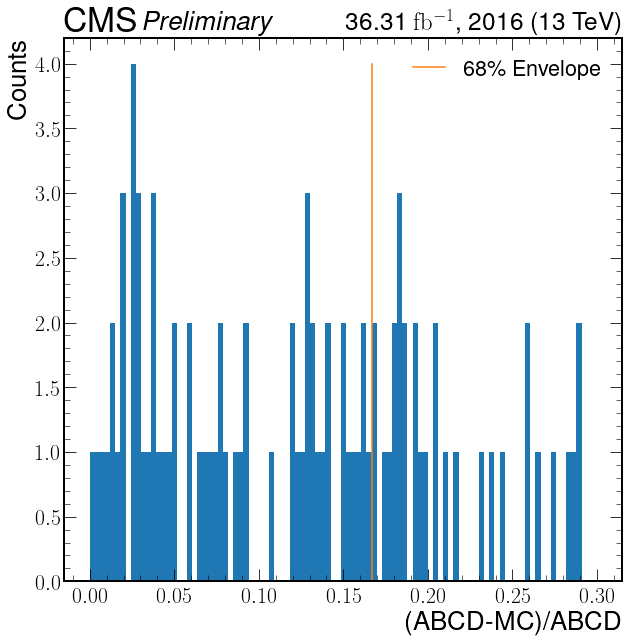

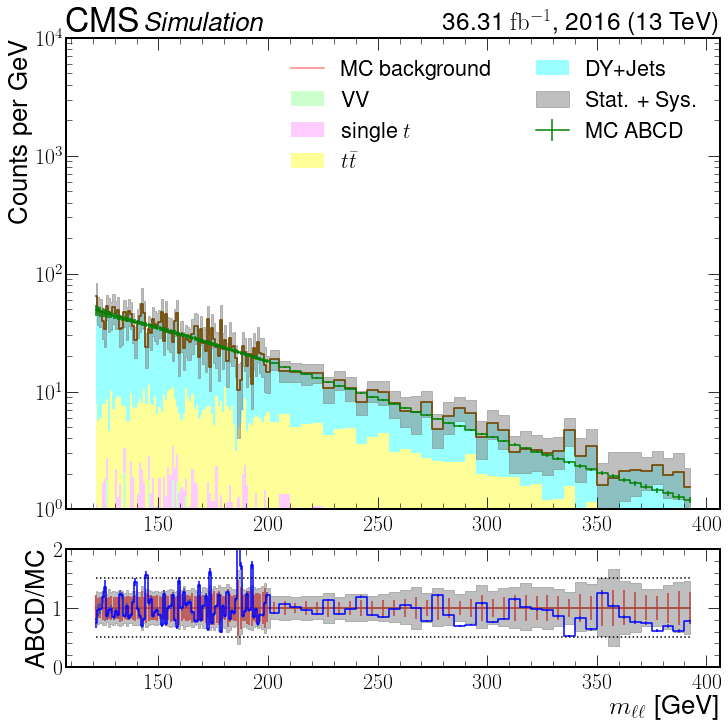

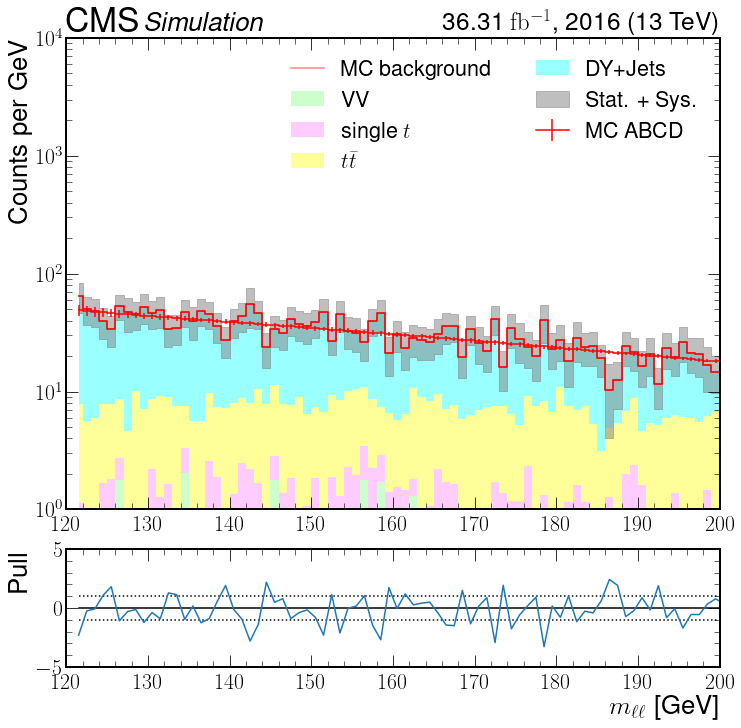

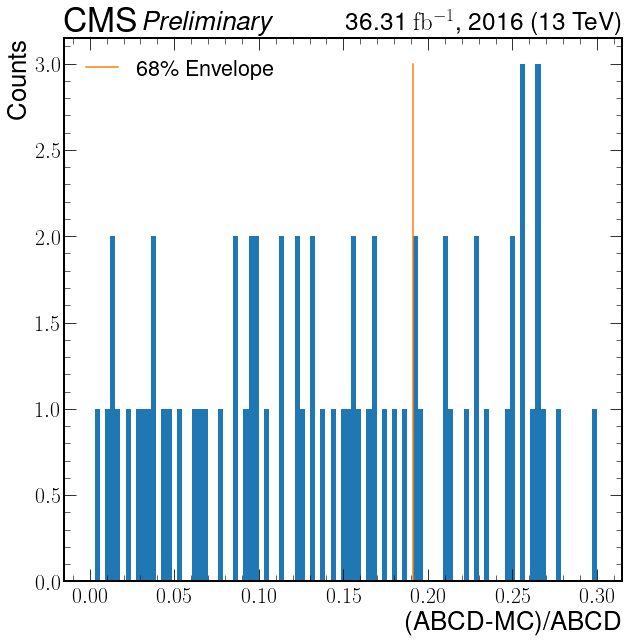

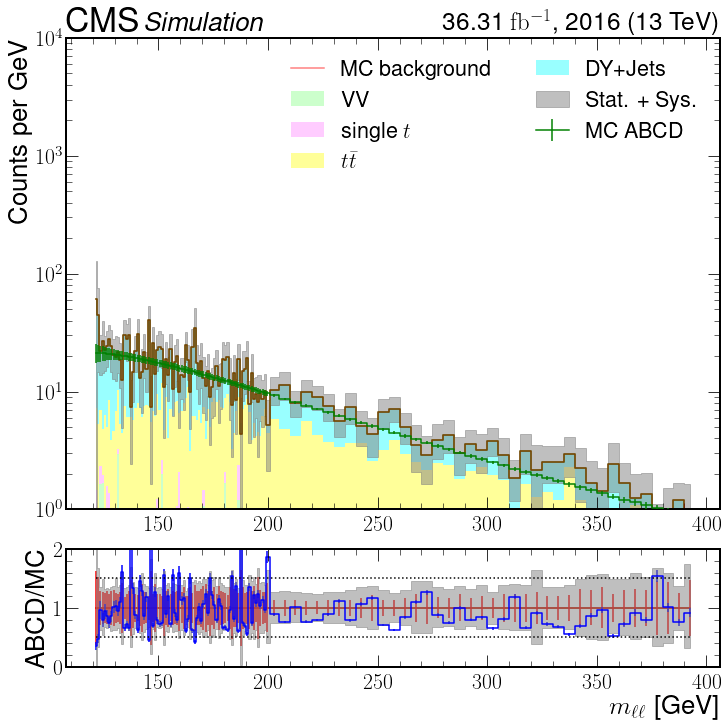

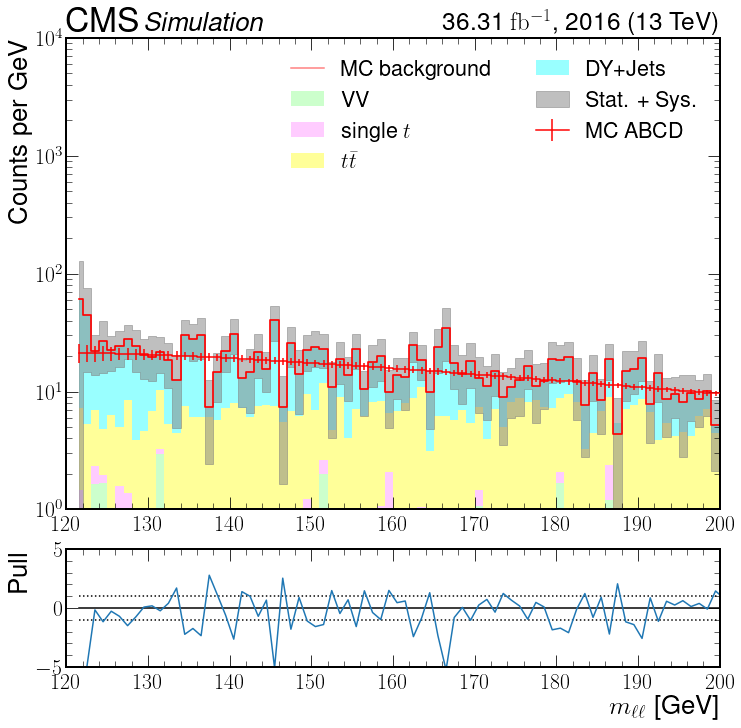

In [33]:
#abcd plots
for nJets in ["","2"]:
    reg = 'CRA{}{}'.format(nJets,postfix)
    #reg = 'CRA{}'.format(nJets)
    #make abcd hist
    abcd_hist = make_abcd(nJets)
    abcd_hist = abcd_hist.rebin(split_bins.bin_edges).reduce_range(bottom=bottom_value, top=top_value).make_density_hist()
    #background hist
    sp.rebin = split_bins.bin_edges
    bhist = sp.combine_back(feature, reg).rebin(split_bins.bin_edges).reduce_range(bottom=bottom_value, top=top_value).make_density_hist()
    #data hist
    #dhist = sp.make_data_hist(feature, reg)
    #reduce the range for fitting
    #dhist = dhist.reduce_range(bottom=bottom_value, top=top_value).make_density_hist()
    
    closure_percent = find_68_env(abcd_hist.nominal, bhist.nominal, nJets)

    flabel = 'Obs. ABCD' if isdata else 'MC ABCD'
    ratio_dict = compare_hists(abcd_hist, bhist, isdata=0, n=comp_hist_n, 
                                   color = 'Green', ndof=5, flabel=flabel, ratio=True, isabcd=1, dhist_isdata=isdata)
    
    sp.draw_background(ratio_dict['ax'], feature, reg, sys_label='Stat. + Sys.', errorbar=False)
    
    ratio_dict['rax'].errorbar(bhist.calc_bin_centers(), bhist.nominal/bhist.nominal,
                                yerr=bhist.std/bhist.nominal, color='red', zorder=.5) 
    # color points outside of 68% CL
    #draw_outside_closure(ratio_dict['ax'], dhist.calc_bin_centers(), dhist.nominal, abcd_hist.nominal, dhist.std, closure_percent, color='red', zorder=6)
    #draw_outside_closure(ratio_dict['rax'], dhist.calc_bin_centers(), dhist.nominal/dhist.nominal, 
    #                     abcd_hist.nominal/dhist.nominal, dhist.std/dhist.nominal, closure_percent, color='red', zorder=6)

    handles, labels = ratio_dict['ax'].get_legend_handles_labels()
    order = [0,1,2,3,4,6,5]
    if ismc: order = np.linspace(0,len(handles)-1, len(handles), dtype=int)
    ratio_dict['ax'].legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
                                ncol=2)
    
    ratio_dict['ax'].set_ylim(bottom=1e0, top=1e4)
    ratio_dict['fig'].savefig('{}/abcd_mc_ratio_era{}_ismc{}_regCR{}{}_bottom{}_lognorm_splt_binning.pdf'.format(outdir,era,ismc,nJets,postfix,bottom_value))
    ##200 GeV zoom in 
    #ratio_dict['ax'].set_xlim(left=bottom_value, right=200)
    #ratio_dict['rax'].set_xlim(left=bottom_value, right=200)
    #ratio_dict['fig'].savefig('{}/abcd_mc_ratio_era{}_ismc{}_regCR{}{}_bottom{}_lognorm_splt_binning_200GeVMax.pdf'.format(outdir,era,ismc,nJets,postfix,bottom_value))

    #ratio
    #pull
    pull_dict = compare_hists(abcd_hist, bhist, isdata=1, n=comp_hist_n, 
                                   color = 'red', ndof=5, flabel=flabel, ratio=False, isabcd=1, dhist_isdata=isdata)
    
    sp.draw_background(pull_dict['ax'], feature, reg, sys_label='Stat. + Sys.', errorbar=False)
    handles, labels = pull_dict['ax'].get_legend_handles_labels()
    order = [0,1,2,3,4,6,5]
    if ismc: order = np.linspace(0,len(handles)-1, len(handles), dtype=int)
    pull_dict['ax'].legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
                                ncol=2)
    pull_dict['ax'].set_ylim(bottom=1e0, top=1e4)
    pull_dict['fig'].savefig('{}/abcd_mc_pull_era{}_ismc{}_regCR{}{}_bottom{}_lognorm_splt_binning.pdf'.format(outdir,era,ismc,nJets,postfix,bottom_value))
    #200 GeV zoom in 
    pull_dict['ax'].set_xlim(left=bottom_value, right=200)
    pull_dict['rax'].set_xlim(left=bottom_value, right=200)
    pull_dict['fig'].savefig('{}/abcd_mc_pull_era{}_ismc{}_regCR{}{}_bottom{}_lognorm_splt_binning_200GeVMax.pdf'.format(outdir,era,ismc,nJets,postfix,bottom_value))
    sp.rebin = 0

    #save data
    fit_dict['CRA{}{}_ABCD'.format(nJets, postfix)]= ratio_dict
    fit_dict['CRA{}{}_ABCD'.format(nJets, postfix)]['fit_hist'] = abcd_hist

In [23]:
{reg: item['chi2'] for reg, item in fit_dict.items()}

{'CRA': nan,
 'CRB': nan,
 'CRC': nan,
 'CRD': nan,
 'CRA2': nan,
 'CRB2': nan,
 'CRC2': nan,
 'CRD2': nan,
 'CRA_ABCD': 1.2198912470974936,
 'CRA2_ABCD': 2.5537144593921774}

In [24]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [34]:
import inspect

In [35]:
reg

'CRA2'

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/SysHist.py:131: RuntimeWarning: invalid value encountered in double_scalars
  std_sig = sys_diff/abs(sys_diff)


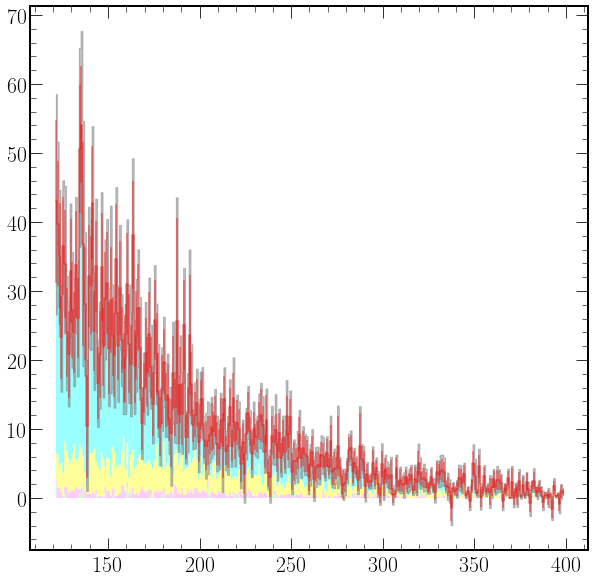

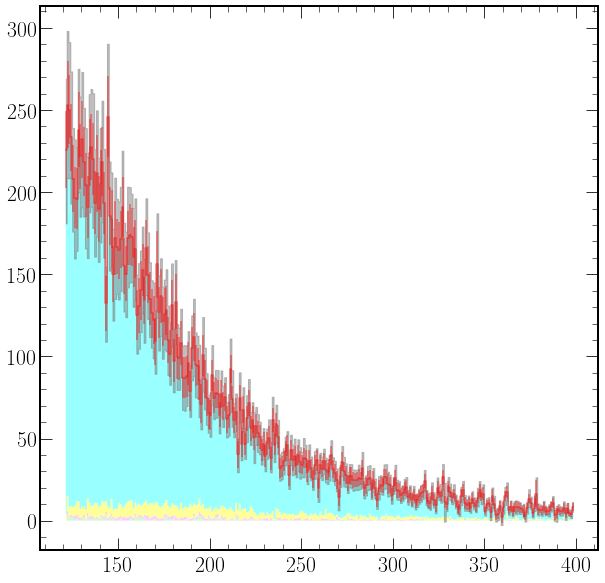

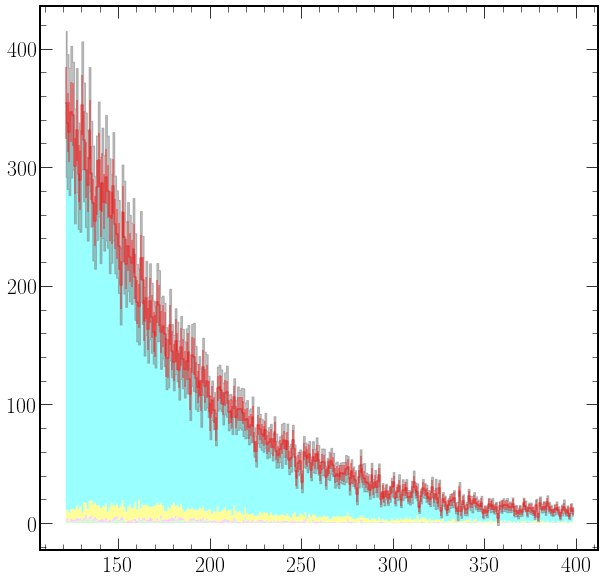

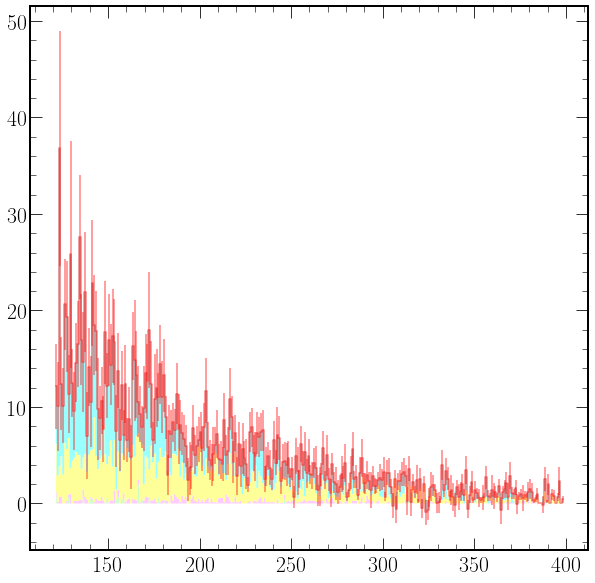

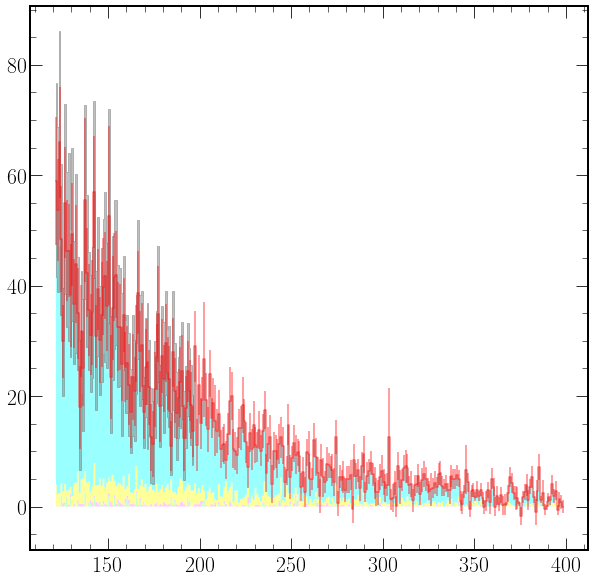

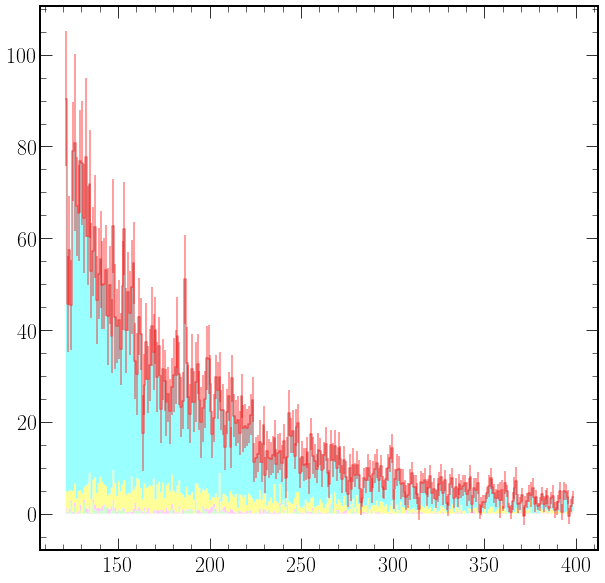

In [40]:
fit_list = []
for reg, item in fit_dict.items():
    if "ABCD" in reg: continue
    if "CRA" in reg: continue
    if isdata:
        _plot_dict = sp.make_data_hist(feature, reg).reduce_range(bottom=bottom_value, top=top_value)
    else:
        fig, ax = plt.subplots()
        _plot_dict = sp.draw_background(ax, feature, reg).reduce_range(bottom=bottom_value, top=top_value)
    _fit_dict = {
        "era": era,
        "region": reg,
    'n_{background}': "{:.2f}".format(_plot_dict.uncertainty_std_dev().sum()),
    'n_{ABCD,Data}': "{:.2f}".format(item['fit_hist'].uncertainty_std_dev().sum()),
    ' Data $\chi^2/n_{DOF}$': "{:.2f}".format(item['chi2'])
    }
    if not 'SR' in reg:
        popt_unc = uncertainties.correlated_values(item['popt'], item['pcov'])
        param_names = inspect.getfullargspec(log_norm_np).args[1:]
        treg_dict = {**{n:"{:.2f}".format(u) for u, n in zip(popt_unc, param_names) }}
        _fit_dict = {**_fit_dict, **treg_dict}    
    fit_list.append(_fit_dict)

In [41]:
with open('{}/fit_stats_data_{}_ismc{}.txt'.format(outdir,era, ismc), 'w') as f:
    latex = pd.DataFrame(fit_list)[['era', 'region', 'n_{background}',  'n_{ABCD,Data}', 'sigma', 'theta', 'mean',
       ' Data $\chi^2/n_{DOF}$']].to_latex(index=False)
    print(latex)
    f.write(latex)

\begin{tabular}{llllllll}
\toprule
 era & region &    n\_\{background\} &    n\_\{ABCD,Data\} &       sigma &         theta &           mean &  Data \$\textbackslash chi\textasciicircum 2/n\_\{DOF\}\$ \\
\midrule
2016 &    CRB &   2717.22+/-64.75 &  2717.22+/-11.11 & 0.61+/-0.13 & 50.00+/-50.59 &  94.17+/-27.86 &                    nan \\
2016 &    CRC & 17404.75+/-170.37 & 17404.75+/-31.14 & 0.82+/-0.05 &  88.23+/-8.96 &   66.77+/-4.02 &                    nan \\
2016 &    CRD & 24596.21+/-197.69 & 24596.21+/-32.88 & 0.76+/-0.05 & 62.13+/-19.39 &   74.44+/-6.00 &                    nan \\
2016 &   CRB2 &   1480.36+/-43.77 &   1480.36+/-7.75 & 0.62+/-0.15 & 54.22+/-54.41 & 100.00+/-33.04 &                    nan \\
2016 &   CRC2 &   3684.32+/-79.83 &  3684.32+/-13.20 & 0.71+/-0.17 & 50.00+/-68.53 &  86.06+/-25.28 &                    nan \\
2016 &   CRD2 &   5199.42+/-93.88 &  5199.42+/-15.33 & 0.80+/-0.17 & 50.00+/-74.68 &  78.76+/-14.57 &                    nan \\
\bottomrule
\end{ta

In [42]:
tdf = pd.DataFrame(fit_list)[['era', 'region', 'n_{background}',  'sigma', 'theta', 'mean', 'n_{ABCD,Data}',
       ' Data $\chi^2/n_{DOF}$']]
tdf

tdf = pd.DataFrame(fit_list)[['era', 'region', 'n_{background}',  'sigma', 'theta', 'mean', 'n_{ABCD,Data}']]
tdf

,era,region,n_{background},sigma,theta,mean,"n_{ABCD,Data}"
0,2016,CRB,2717.22+/-64.75,0.61+/-0.13,50.00+/-50.59,94.17+/-27.86,2717.22+/-11.11
1,2016,CRC,17404.75+/-170.37,0.82+/-0.05,88.23+/-8.96,66.77+/-4.02,17404.75+/-31.14
2,2016,CRD,24596.21+/-197.69,0.76+/-0.05,62.13+/-19.39,74.44+/-6.00,24596.21+/-32.88
3,2016,CRB2,1480.36+/-43.77,0.62+/-0.15,54.22+/-54.41,100.00+/-33.04,1480.36+/-7.75
4,2016,CRC2,3684.32+/-79.83,0.71+/-0.17,50.00+/-68.53,86.06+/-25.28,3684.32+/-13.20
5,2016,CRD2,5199.42+/-93.88,0.80+/-0.17,50.00+/-74.68,78.76+/-14.57,5199.42+/-15.33


In [ ]:
40665*5778.39/28601

In [ ]:
#format dict for saving
limit_dict = {}
for reg, item in fit_dict.items():
    limit_dict[reg] = item['fit_hist'].to_dict()

In [ ]:
import pickle as pkl
with open('{}/abcd_dict_data_{}_ismc{}.pkl'.format(outdir, era, ismc), 'wb') as f:
    pkl.dump(limit_dict, f)

In [ ]:
fit_dict_skimmed = {}
for k, v in fit_dict.items():
    v = {k2:v2 for k2,v2 in v.items() if not k2 in ['fig', 'ax','rax']}
    fit_dict_skimmed[k] = v

In [ ]:
import pickle as pkl
with open('{}/fit_dict_data_{}_ismc{}.pkl'.format(outdir, era, ismc), 'wb') as f:
    pkl.dump(fit_dict_skimmed, f)

In [ ]:
'{}/abcd_dict_data_{}_ismc{}.pkl'.format(outdir, era, ismc)

In [ ]:
from src.assets.regions import regions
from uncertainties import ufloat

In [ ]:
for reg in regions:
    sp.combine_back(feature, reg)

In [ ]:
#region composition
reg_list = []
for reg in test_regions:
    bdf = sp.bck_df(feature, reg)
    print(reg)
    reg_dict = {'reg': reg}
    
    total = 0
    category = "" 
    cat_sum = 0
    for i, row in bdf.iterrows():
        if row.category not in reg_dict:
            reg_dict[row.category] = 0
        reg_sum = row.nom.sum()
        reg_std = row.nom.std()
        print(row.category, reg_sum, reg_std)
        reg_dict[row.category] += reg_sum
        total+=row.nom.sum()
    reg_list.append(reg_dict)
    print("----")
    for i, row in bdf.iterrows():
        print(row.category, row.nom.sum()/total) 
    print("---\n")

In [ ]:
df = pd.DataFrame(reg_list)

In [ ]:
sum_axis1 = df[['DY', 'TT', 'ST', 'VB']].sum(axis=1)

In [ ]:
prop_df = df[['DY', 'TT', 'ST', 'VB']].div(sum_axis1, axis=0)

In [ ]:
prop_df['reg'] = df.reg

In [ ]:
df

In [ ]:
for i, row in prop_df [['reg', 'DY', 'TT', 'ST', 'VB']].iterrows():
    print("{reg} & {DY:.2f} &  {TT:.2f} & {ST:.2f} & {VB:.2f} \\\\".format(**row.to_dict()))

In [ ]:
prop_df